In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

import pandas as pd
torch.cuda.set_device(1)

In [4]:
PATH = 'data/eeg/csv/'

In [5]:
folders = ['train', 'test']

In [6]:
tables = [pd.read_csv(f'{PATH}{folder}.csv', low_memory = False) for folder in folders]

## Plotting the trainning data 

In [7]:
train = tables[0]
train_response = train['response']
train_input = train.drop('response', axis = 1)

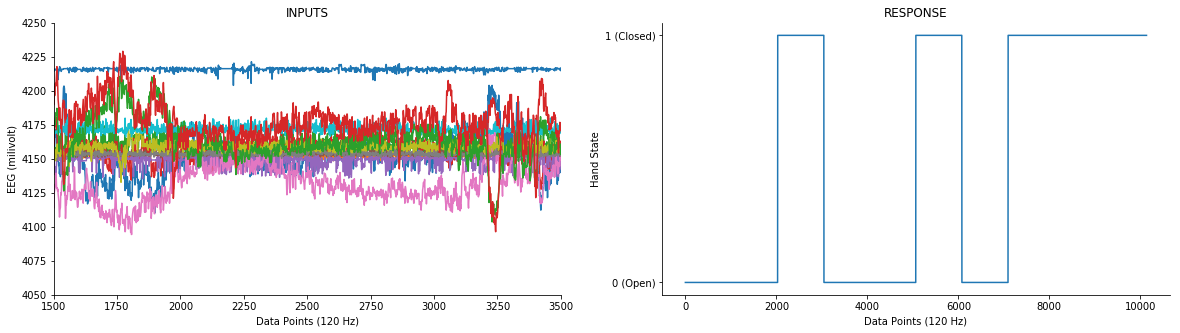

In [8]:
fig, axis = plt.subplots(1,2)
fig.set_size_inches(20, 5)

train_input.plot(ax = axis[0], legend = None)
axis[0].set_xlim(1500, 3500)
axis[0].set_ylim(4050, 4250)
axis[0].set_title('INPUTS')
axis[0].set_title('INPUTS')
axis[0].spines['right'].set_visible(False)
axis[0].spines['top'].set_visible(False)
axis[0].set_xlabel('Data Points (120 Hz)')
axis[0].set_ylabel('EEG (milivolt)')

train_response.plot(ax = axis[1])
#axis[1].set_xlim(1500, 3500)
axis[1].set_title('RESPONSE')
axis[1].spines['right'].set_visible(False)
axis[1].spines['top'].set_visible(False)
axis[1].set_xlabel('Data Points (120 Hz)')
axis[1].set_ylabel('Hand State')
axis[1].set_yticks([0, 1])
axis[1].set_yticklabels(['0 (Open)', '1 (Closed)'])

plt.show()

The data is composed by 14 signals comming from electrodes attached to the person head. We want to use this signals and be able to infer when the person is thinking about closing its hand.

## Data Cleaning/Handling

Since we do not have categorical variables we need to create a dummy variable to be considered as a categorical one. If we dont do that `ColumnarModelData` returns a error

In [9]:
for t in tables: 
    t['dummy'] = 0
    display(t.head())

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,response,dummy
0,4136.4,4150.8,4160.0,4156.9,4151.8,4155.4,4139.5,4154.9,4159.5,4172.3,4214.4,4935.4,4154.4,4187.7,0,0
1,4142.1,4150.8,4160.5,4160.5,4151.3,4154.4,4141.5,4152.8,4159.5,4170.8,4215.4,4933.8,4148.7,4185.6,0,0
2,4147.7,4150.3,4159.0,4162.6,4150.8,4153.8,4141.5,4153.3,4161.5,4172.8,4214.9,4936.9,4147.7,4180.5,0,0
3,4146.2,4150.8,4158.5,4160.0,4149.7,4153.3,4135.9,4154.9,4159.0,4178.5,4215.4,4937.9,4151.3,4180.5,0,0
4,4142.1,4151.3,4161.0,4154.4,4151.3,4154.4,4132.3,4153.8,4155.4,4174.4,4216.4,4935.4,4153.3,4187.2,0,0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,response,dummy
0,4161.5,4153.3,4159.0,4154.4,4149.7,4154.4,4136.9,4153.3,4161.0,4174.9,4216.9,4938.5,4156.4,4188.2,0,0
1,4159.0,4152.3,4159.5,4157.4,4150.3,4155.4,4137.9,4155.4,4159.0,4172.3,4216.9,4938.5,4155.9,4187.7,0,0
2,4155.9,4152.8,4156.9,4153.8,4147.7,4154.9,4139.0,4153.8,4161.5,4172.3,4216.9,4937.4,4150.8,4182.6,0,0
3,4159.0,4152.3,4159.0,4152.8,4148.7,4153.8,4140.5,4152.8,4162.1,4171.3,4216.4,4937.9,4150.3,4181.5,0,0
4,4162.1,4151.3,4161.0,4156.9,4151.8,4154.4,4139.5,4154.9,4162.1,4170.8,4216.4,4939.5,4151.3,4180.5,0,0


In [60]:
data_train, data_test = tables
sample_size = len(data_train)

In [61]:
cat_vars = ['dummy']
contin_vars = ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14',]

In [62]:
for v in cat_vars: data_train[v] = data_train[v].astype('category').cat.as_ordered()

In [63]:
for v in contin_vars:
    data_train[v] = data_train[v].astype('float32')

In [65]:
train_ratio = 0.8
#train_size = int(sample_size * train_ratio)
#val_idx = list(range(train_size, len(data_train)))
val_idx = get_cv_idxs(sample_size, val_pct = 1 - train_ratio)
val_size = len(val_idx)
train_size = sample_size - val_size

In [66]:
df = data_train.drop('response', axis = 1)
y = data_train['response']

## Deep Learning

In [67]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds = ['dummy'], bs = 64)

In [68]:
cat_sz = [(c, len(data_train[c].cat.categories) + 1) for c in ['dummy']]; cat_sz

[('dummy', 2)]

In [69]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]; emb_szs

[(2, 1)]

In [70]:
m = md.get_learner(emb_szs, len(df.columns) - len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=(0,1))

In [75]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.49926    0.496094  



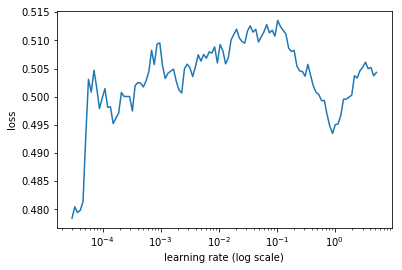

In [76]:
m.sched.plot()

The loss is not decreasing at all which indicates that no learning seems to be taking place. Lets pick up a learning rate of 1e-3 just to see if we got any improvements.

In [77]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=(0, 1))
lr = 1e-3

In [78]:
m.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.492764   0.503906  
    1      0.496016   0.503906                                
    2      0.492708   0.503906                                



[0.50390625]

In [79]:
y_predict, y_data= m.predict_with_targs()

In [88]:
accuracy = (sum(y_predict == y_data) / val_size)[0]; accuracy

0.4908732116428219